In [605]:
import os
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats import iqr

In [606]:
project_dir = '/Users/xiaoqianxiao/projects/NARSAD'
SCR_dir = os.path.join(project_dir, 'EDR')
acquisition_file = os.path.join(SCR_dir, 'peak_stats_table-phase1.csv')
phase2and3_file = os.path.join(SCR_dir, 'peak_stats_table-phase2.3.csv')
drug_file = os.path.join(SCR_dir, 'drug_order.csv')
ECR_file = os.path.join(SCR_dir, 'ECR.csv')

In [607]:
df_acquisition = pd.read_csv(acquisition_file)
df_acquisition['stage'] = 'acquisition'
df_acquisition.loc[df_acquisition['stTy']=='CS+R','CS_Type'] = 'CS+_Reinf'
df_acquisition.loc[df_acquisition['stTy']=='CS+S','CS_Type'] = 'CS+_Safe'
df_acquisition.loc[df_acquisition['stTy']=='CS-','CS_Type'] = 'CS-'
print(df_acquisition.head())

    sid  stTy  stNum  bTime  tonBase  phaBase  phaMax  phaBase2Peak  \
0  N101  CS+R      1  710.1    0.429   -0.048  -0.030         0.019   
1  N101  CS+S      2  729.1    0.776   -0.069  -0.016         0.052   
2  N101   CS-      3  749.2    0.875   -0.005   0.001         0.006   
3  N101  CS+R      4  767.2    0.738   -0.020  -0.019         0.001   
4  N101  CS+S      5  786.2    0.881   -0.171  -0.007         0.164   

   phaPeakLatency  phaMinLatency  USPeakLatency  phaMaxUS  USminLatency  \
0           712.2          710.2          720.5  0.218286         717.5   
1           734.4          732.2          739.3  0.115014         736.5   
2           753.8          749.7          760.2  0.000766         757.3   
3           769.8          769.2          777.3  0.081659         774.5   
4           791.7          789.6          796.1  0.256895         793.4   

   phaMinUS  USbase2peak  bad        stage    CS_Type  
0 -0.194254        0.413    0  acquisition  CS+_Reinf  
1 -0.06618

In [608]:
df_phase2and3 = pd.read_csv(phase2and3_file)
df_phase2and3.loc[df_phase2and3['stNum']<=24,'stage'] = 'extinction'
df_phase2and3.loc[df_phase2and3['stNum']>=25,'stage'] = 'reinstatement'
df_phase2and3.loc[df_phase2and3['stTy']=='CS+R','CS_Type'] = 'CS+_Reinf'
df_phase2and3.loc[df_phase2and3['stTy']=='CS+S','CS_Type'] = 'CS+_Safe'
df_phase2and3.loc[df_phase2and3['stTy']=='CS-','CS_Type'] = 'CS-'
print(df_phase2and3.head())

    sid  stTy  stNum  bTime  tonBase  phaBase  phaMax  phaBase2Peak  \
0  N101   CS-      1  728.3    3.765   -0.014   0.009         0.023   
1  N101  CS+R      2  747.3    3.735   -0.016   0.022         0.037   
2  N101  CS+S      3  766.3    3.708   -0.018   0.002         0.020   
3  N101  CS+S      4  786.3    3.849    0.001   0.015         0.015   
4  N101  CS+R      5  804.3    3.791   -0.061   0.041         0.103   

   phaPeakLatency  phaMinLatency  USPeakLatency  phaMaxUS  USminLatency  \
0           732.6          732.1          734.6  0.009600         734.3   
1           750.6          747.7          753.3  0.012400         753.3   
2           768.6          768.1          772.9 -0.001971         772.5   
3           788.6          787.4          794.6  0.009572         793.4   
4           809.8          807.8          810.6  0.066508         810.3   

   phaMinUS  USbase2peak  bad       stage    CS_Type  
0  0.002594        0.007    0  extinction        CS-  
1  0.012400 

In [609]:
df_drug = pd.read_csv(drug_file)
df_drug['group'] = df_drug['subID'].apply(lambda x: 'Patients' if x.startswith('N1') else 'Controls')
df_ECR = pd.read_csv(ECR_file)
df_behav = df_drug.merge(df_ECR, how='left', left_on='subID', right_on='subID')

In [610]:
df_all_acquisition = pd.merge(df_acquisition, df_behav, left_on='sid', right_on='subID', how='left')
rejTrials = df_all_acquisition[df_all_acquisition['phaBase2Peak'] < 0].index
df_all_acquisition.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all_acquisition['rejTrials'] = 0
df_all_acquisition.loc[rejTrials, 'rejTrials'] = 1
df_all_acquisition = df_all_acquisition[df_all_acquisition['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)
df_all_phase2and3 = pd.merge(df_phase2and3, df_behav, left_on='sid', right_on='subID', how='left')
df_all_phase2and3 = df_all_phase2and3[df_all_phase2and3['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)
rejTrials = df_all_phase2and3[df_all_phase2and3['phaBase2Peak'] < 0.01].index
df_all_phase2and3.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all_phase2and3['rejTrials'] = 0
df_all_phase2and3.loc[rejTrials, 'rejTrials'] = 1

In [611]:
df_all_phases = pd.concat([df_acquisition,df_phase2and3])
merged_df = pd.merge(df_all_phases, df_behav, left_on='sid', right_on='subID', how='left')
#get no responder as reject trials
df_all = merged_df.copy()
rejTrials = df_all[df_all['phaBase2Peak'] < 0.01].index
df_all.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all['rejTrials'] = 0
df_all.loc[rejTrials, 'rejTrials'] = 1
df_all = df_all[df_all['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)

In [612]:
# Check existing of miss-data subjects
# generate df_filtered with only subjects have all trails 
# Define expected structure
conditions = 3  # e.g., CS types
stages = 3     # 'acquisition', 'extinction', 'reinstatement'
trials_per_cond_stage = 8
expected_rows = conditions * stages * trials_per_cond_stage  # 3 * 3 * 8 = 72

# Step 1: Count rows per sid
sid_counts = df_all.groupby('sid').size()
print("Row counts per sid:")
print(sid_counts)

# Step 2: Identify sids with exactly 72 rows
valid_sids = sid_counts[sid_counts == expected_rows].index
print(f"\nNumber of sids with exactly {expected_rows} rows: {len(valid_sids)}")
print("Valid sids:", valid_sids.tolist())

# Step 3: Filter df_final to keep only sids with 72 rows
df_filtered = df_all[df_all['sid'].isin(valid_sids)].copy()
print(f"\nFiltered DataFrame size: {df_filtered.shape}")
print("Unique sids in filtered data:", df_filtered['sid'].nunique())

# Verify structure (assuming a condition column exists, e.g., 'CS_Type')
if 'CS_Type' in df_filtered.columns:  # Replace 'CS_Type' with your condition column name if different
    structure_check = df_filtered.groupby(['sid', 'stage', 'CS_Type']).size()
    print("\nTrial counts per sid, stage, and condition in filtered data:")
    print(structure_check)
else:
    structure_check = df_filtered.groupby(['sid', 'stage']).size()
    print("\nTrial counts per sid and stage in filtered data (assuming 24 trials/stage):")
    print(structure_check)

# Step 4: Identify and summarize sids with fewer than 72 rows
invalid_sids = sid_counts[sid_counts < expected_rows].index
print(f"\nNumber of sids with fewer than {expected_rows} rows: {len(invalid_sids)}")
print("SIDs with fewer than 72 rows (sid, stage, CS_Type, trial count):")

# Filter invalid sids and group by sid, stage, CS_Type to count trials
if 'CS_Type' in df_filtered.columns:
    df_invalid = df_filtered[df_filtered['sid'].isin(invalid_sids)].groupby(['sid', 'stage', 'CS_Type']).size().reset_index(name='trial_count')
    # Print in requested format
    for index, row in df_invalid.iterrows():
        print(f"sid: {row['sid']}, stage: {row['stage']}, CS_Type: {row['CS_Type']}, trials: {row['trial_count']}")
else:
    df_invalid = df_filtered[df_filtered['sid'].isin(invalid_sids)].groupby(['sid', 'stage']).size().reset_index(name='trial_count')
    # Print without CS_Type if not present
    for index, row in df_invalid.iterrows():
        print(f"sid: {row['sid']}, stage: {row['stage']}, trials: {row['trial_count']}")

print(f"Total rows for invalid sids: {df_all[df_all['sid'].isin(invalid_sids)].shape[0]}")

Row counts per sid:
sid
N101    72
N102    24
N103    72
N104    72
N105    72
        ..
N255    72
N257    72
N258    72
N259    72
N260    72
Length: 103, dtype: int64

Number of sids with exactly 72 rows: 101
Valid sids: ['N101', 'N103', 'N104', 'N105', 'N106', 'N108', 'N109', 'N110', 'N111', 'N112', 'N113', 'N114', 'N115', 'N117', 'N118', 'N121', 'N122', 'N123', 'N124', 'N125', 'N127', 'N128', 'N129', 'N130', 'N131', 'N132', 'N133', 'N134', 'N135', 'N136', 'N137', 'N138', 'N141', 'N142', 'N143', 'N144', 'N145', 'N146', 'N147', 'N148', 'N149', 'N150', 'N151', 'N153', 'N154', 'N155', 'N156', 'N157', 'N158', 'N201', 'N202', 'N203', 'N204', 'N206', 'N207', 'N209', 'N210', 'N211', 'N212', 'N213', 'N214', 'N215', 'N216', 'N217', 'N219', 'N220', 'N221', 'N222', 'N224', 'N225', 'N226', 'N227', 'N228', 'N230', 'N231', 'N232', 'N233', 'N234', 'N235', 'N236', 'N237', 'N238', 'N240', 'N241', 'N242', 'N243', 'N244', 'N246', 'N247', 'N248', 'N249', 'N250', 'N251', 'N252', 'N253', 'N254', 'N255'

In [613]:
# generate df for only responders
df_responder = df_filtered.loc[df_filtered['rejTrials']==0].copy()
df_responder_acquisition = df_all_acquisition.loc[df_all_acquisition['rejTrials']==0].copy()
df_responder_phase2and3 = df_all_phase2and3.loc[df_all_phase2and3['rejTrials']==0].copy()

In [614]:
## Functions for outliers
# Function to detect outliers using IQR (Tukey's Fences)
def count_outliers_iqr(series, k=4):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3 - q1
    lower_bound = q1 - k * iqr_val
    upper_bound = q3 + k * iqr_val
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Function to detect outliers using Modified Z-Score (MAD)
def count_outliers_mad(series, threshold=3.5):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:  # Fallback to IQR if MAD is zero
        return count_outliers_iqr(series, k=3)
    z_m = 0.6745 * (series - median) / mad
    return (abs(z_m) > threshold).sum()

# Define stages and groups
stages = ['acquisition', 'extinction', 'reinstatement']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

In [615]:
#outliers for df_filtered
# Iterate over each group-stage combination
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_filtered[(df_filtered['group'] == group) & 
                           (df_filtered['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3),  # IQR with k=3
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4),  # MAD with threshold=3.5
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())



Checking data for Acquisition - Patients:
  Total rows: 1176
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1176

Descriptive Statistics for Acquisition - Patients:
             N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  1176  0.0000  0.9560  0.0426  0.0000  0.0300           137           137          0

Checking data for Extinction - Patients:
  Total rows: 1176
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1176

Descriptive Statistics for Extinction - Patients:
             N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  1176  0.0000  3.8080  0.0362  0.0220  0.0120            83           104          0

Checking data for Reinstatement - Patients:
  Total rows: 1176
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1176

Descriptive Statistics for Reinstatement - Patients:
             N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Cou

In [616]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Function to detect outliers using IQR (Tukey's Fences)
def count_outliers_iqr(series, k=3):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3 - q1
    lower_bound = q1 - k * iqr_val
    upper_bound = q3 + k * iqr_val
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers  # Return boolean Series

# Function to detect outliers using Modified Z-Score (MAD)
def count_outliers_mad(series, threshold=4):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        print(f"Warning: MAD is zero for this series, falling back to IQR (k={k})")
        return count_outliers_iqr(series, k=3)
    z_m = 0.6745 * (series - median) / mad
    outliers = abs(z_m) > threshold
    return outliers  # Return boolean Series

In [617]:
# Define stages and groups
stages = ['acquisition']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
df_responder_acquisition['outlier_flag_IQR'] = None
df_responder_acquisition['outlier_flag_MAD'] = None


# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_responder_acquisition[(df_responder_acquisition['group'] == group) & 
                              (df_responder_acquisition['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())

    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    
    print(f"  IQR outliers count (k=3): {outliers_iqr.sum()}")
    print(f"  MAD outliers count (threshold=4): {outliers_mad.sum()}")
    print(f"  Detailed IQR outliers (k=3, first 5 indices): {outliers_iqr[outliers_iqr].index.tolist()[:5] or 'None'}")
    print(f"  Detailed MAD outliers (threshold=4, first 5 indices): {outliers_mad[outliers_mad].index.tolist()[:5] or 'None'}")

    # Flag outliers in df_responder
    mask = (df_responder_acquisition['group'] == group) & (df_responder_acquisition['stage'].str.lower() == stage.lower())
    df_responder_acquisition.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df_responder_acquisition.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df_responder_acquisition.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df_responder_acquisition.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None

    # Store outliers for CSV (optional, for completeness)
    for index, row in subset_data.iterrows():
        value = row['phaBase2Peak']
        is_outlier_iqr = outliers_iqr.loc[index] if index in outliers_iqr.index else False
        is_outlier_mad = outliers_mad.loc[index] if index in outliers_mad.index else False
        if is_outlier_iqr or is_outlier_mad:
            outlier_info.append({
                'sid': row['sid'],
                'stage': row['stage'],
                'group': row['group'],
                'CS_Type': row['CS_Type'] if 'CS_Type' in row else None,
                'phaBase2Peak': value,
                'outlier_method': 'IQR' if is_outlier_iqr else 'MAD'
            })

# Convert outlier info to DataFrame and save to CSV (optional)
if outlier_info:
    outlier_df = pd.DataFrame(outlier_info)
    print(f"\nTotal outliers identified: {len(outlier_df)}")
    print("\nSample of outliers (from CSV export):")
    print(outlier_df.head())
    outlier_df.to_csv('outliers_info.csv', index=False)
else:
    print("\nNo outliers identified. This may indicate an issue—checking data...")
    print("Sample of phaBase2Peak values across all data:")
    print(df_responder_acquisition['phaBase2Peak'].describe())
    print("\nPotential issues:")
    print(f"  - Thresholds might be too strict (IQR k=3, MAD threshold=4). Try k=1.5 or threshold=3.5.")
    print(f"  - Data may have been filtered or preprocessed differently. Verify with:")
    print("    print(df_responder.groupby(['stage', 'group'])['phaBase2Peak'].describe())")
    print(f"  - Check for uniform values or NaNs: {df_responder_acquisition['phaBase2Peak'].isna().sum()} NaNs, unique values: {df_responder_acquisition['phaBase2Peak'].nunique()}")

# Display the updated df_responder with outlier flags
print("\nSample of df_responder with outlier flags:")
print(df_responder_acquisition[['sid', 'stage', 'group', 'CS_Type', 'phaBase2Peak', 'outlier_flag_IQR', 'outlier_flag_MAD']].head())


Checking data for Acquisition - Patients:
  Total rows: 1003
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1003
  Sample of phaBase2Peak values: [0.019, 0.052, 0.006, 0.001, 0.164]
  Full phaBase2Peak description:
count    1003.000000
mean        0.051305
std         0.106982
min        -0.000000
25%         0.002000
50%         0.007000
75%         0.043000
max         0.956000
Name: phaBase2Peak, dtype: float64

Descriptive Statistics for Acquisition - Patients:
             N      Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  1003  -0.0000  0.9560  0.0513  0.0070  0.0410            98           233          0
  IQR outliers count (k=3): 98
  MAD outliers count (threshold=4): 233
  Detailed IQR outliers (k=3, first 5 indices): [50, 51, 52, 65, 194]
  Detailed MAD outliers (threshold=4, first 5 indices): [1, 4, 16, 48, 49]

Checking data for Acquisition - Controls:
  Total rows: 1106
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN

In [618]:
# Define stages and groups
stages = ['extinction', 'reinstatement']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
# df_responder_acquisition['outlier_flag_IQR'] = None
# df_responder_acquisition['outlier_flag_MAD'] = None
df_responder_phase2and3['outlier_flag_IQR'] = None
df_responder_phase2and3['outlier_flag_MAD'] = None

# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_responder_phase2and3[(df_responder_phase2and3['group'] == group) & 
                              (df_responder_phase2and3['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())

    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    
    print(f"  IQR outliers count (k=3): {outliers_iqr.sum()}")
    print(f"  MAD outliers count (threshold=4): {outliers_mad.sum()}")
    print(f"  Detailed IQR outliers (k=3, first 5 indices): {outliers_iqr[outliers_iqr].index.tolist()[:5] or 'None'}")
    print(f"  Detailed MAD outliers (threshold=4, first 5 indices): {outliers_mad[outliers_mad].index.tolist()[:5] or 'None'}")

    # Flag outliers in df_responder
    mask = (df_responder_phase2and3['group'] == group) & (df_responder_phase2and3['stage'].str.lower() == stage.lower())
    df_responder_phase2and3.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df_responder_phase2and3.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df_responder_phase2and3.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df_responder_phase2and3.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None

    # Store outliers for CSV (optional, for completeness)
    for index, row in subset_data.iterrows():
        value = row['phaBase2Peak']
        is_outlier_iqr = outliers_iqr.loc[index] if index in outliers_iqr.index else False
        is_outlier_mad = outliers_mad.loc[index] if index in outliers_mad.index else False
        if is_outlier_iqr or is_outlier_mad:
            outlier_info.append({
                'sid': row['sid'],
                'stage': row['stage'],
                'group': row['group'],
                'CS_Type': row['CS_Type'] if 'CS_Type' in row else None,
                'phaBase2Peak': value,
                'outlier_method': 'IQR' if is_outlier_iqr else 'MAD'
            })

# Convert outlier info to DataFrame and save to CSV (optional)
if outlier_info:
    outlier_df = pd.DataFrame(outlier_info)
    print(f"\nTotal outliers identified: {len(outlier_df)}")
    print("\nSample of outliers (from CSV export):")
    print(outlier_df.head())
    outlier_df.to_csv('outliers_info.csv', index=False)
else:
    print("\nNo outliers identified. This may indicate an issue—checking data...")
    print("Sample of phaBase2Peak values across all data:")
    print(df_responder_phase2and3['phaBase2Peak'].describe())
    print("\nPotential issues:")
    print(f"  - Thresholds might be too strict (IQR k=3, MAD threshold=4). Try k=1.5 or threshold=3.5.")
    print(f"  - Data may have been filtered or preprocessed differently. Verify with:")
    print("    print(df_responder.groupby(['stage', 'group'])['phaBase2Peak'].describe())")
    print(f"  - Check for uniform values or NaNs: {df_responder_phase2and3['phaBase2Peak'].isna().sum()} NaNs, unique values: {df_responder_phase2and3['phaBase2Peak'].nunique()}")

# Display the updated df_responder with outlier flags
print("\nSample of df_responder with outlier flags:")
print(df_responder_phase2and3[['sid', 'stage', 'group', 'CS_Type', 'phaBase2Peak', 'outlier_flag_IQR', 'outlier_flag_MAD']].head())


Checking data for Extinction - Patients:
  Total rows: 1120
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1120
  Sample of phaBase2Peak values: [0.023, 0.037, 0.02, 0.015, 0.103]
  Full phaBase2Peak description:
count    1120.000000
mean        0.037991
std         0.123908
min         0.010000
25%         0.018000
50%         0.023000
75%         0.030000
max         3.808000
Name: phaBase2Peak, dtype: float64

Descriptive Statistics for Extinction - Patients:
             N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  1120  0.0100  3.8080  0.0380  0.0230  0.0120            80           102          0
  IQR outliers count (k=3): 80
  MAD outliers count (threshold=4): 102
  Detailed IQR outliers (k=3, first 5 indices): [4, 57, 240, 258, 298]
  Detailed MAD outliers (threshold=4, first 5 indices): [4, 57, 240, 258, 298]

Checking data for Reinstatement - Patients:
  Total rows: 1140
  phaBase2Peak NaN count: 0
  phaBase2Peak non-N

In [620]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Function to detect outliers using IQR (Tukey's Fences)
def count_outliers_iqr(series, k=3):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3 - q1
    lower_bound = q1 - k * iqr_val
    upper_bound = q3 + k * iqr_val
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers  # Return boolean Series

# Function to detect outliers using Modified Z-Score (MAD)
def count_outliers_mad(series, threshold=4):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        print(f"Warning: MAD is zero for this series, falling back to IQR (k={k})")
        return count_outliers_iqr(series, k=3)
    z_m = 0.6745 * (series - median) / mad
    outliers = abs(z_m) > threshold
    return outliers  # Return boolean Series

# Define stages and groups
stages = ['acquisition', 'extinction', 'reinstatement']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
df_responder['outlier_flag_IQR'] = None  # Flag for IQR outliers
df_responder['outlier_flag_MAD'] = None  # Flag for MAD outliers

# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_responder[(df_responder['group'] == group) & 
                              (df_responder['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())

    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    
    print(f"  IQR outliers count (k=3): {outliers_iqr.sum()}")
    print(f"  MAD outliers count (threshold=4): {outliers_mad.sum()}")
    print(f"  Detailed IQR outliers (k=3, first 5 indices): {outliers_iqr[outliers_iqr].index.tolist()[:5] or 'None'}")
    print(f"  Detailed MAD outliers (threshold=4, first 5 indices): {outliers_mad[outliers_mad].index.tolist()[:5] or 'None'}")

    # Flag outliers in df_responder
    mask = (df_responder['group'] == group) & (df_responder['stage'].str.lower() == stage.lower())
    df_responder.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df_responder.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df_responder.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df_responder.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None

    # Store outliers for CSV (optional, for completeness)
    for index, row in subset_data.iterrows():
        value = row['phaBase2Peak']
        is_outlier_iqr = outliers_iqr.loc[index] if index in outliers_iqr.index else False
        is_outlier_mad = outliers_mad.loc[index] if index in outliers_mad.index else False
        if is_outlier_iqr or is_outlier_mad:
            outlier_info.append({
                'sid': row['sid'],
                'stage': row['stage'],
                'group': row['group'],
                'CS_Type': row['CS_Type'] if 'CS_Type' in row else None,
                'phaBase2Peak': value,
                'outlier_method': 'IQR' if is_outlier_iqr else 'MAD'
            })

# Convert outlier info to DataFrame and save to CSV (optional)
if outlier_info:
    outlier_df = pd.DataFrame(outlier_info)
    print(f"\nTotal outliers identified: {len(outlier_df)}")
    print("\nSample of outliers (from CSV export):")
    print(outlier_df.head())
    outlier_df.to_csv('outliers_info.csv', index=False)
else:
    print("\nNo outliers identified. This may indicate an issue—checking data...")
    print("Sample of phaBase2Peak values across all data:")
    print(df_responder['phaBase2Peak'].describe())
    print("\nPotential issues:")
    print(f"  - Thresholds might be too strict (IQR k=3, MAD threshold=4). Try k=1.5 or threshold=3.5.")
    print(f"  - Data may have been filtered or preprocessed differently. Verify with:")
    print("    print(df_responder.groupby(['stage', 'group'])['phaBase2Peak'].describe())")
    print(f"  - Check for uniform values or NaNs: {df_responder['phaBase2Peak'].isna().sum()} NaNs, unique values: {df_responder['phaBase2Peak'].nunique()}")

# Display the updated df_responder with outlier flags
print("\nSample of df_responder with outlier flags:")
print(df_responder[['sid', 'stage', 'group', 'CS_Type', 'phaBase2Peak', 'outlier_flag_IQR', 'outlier_flag_MAD']].head())


Checking data for Acquisition - Patients:
  Total rows: 457
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 457
  Sample of phaBase2Peak values: [0.019, 0.052, 0.164, 0.01, 0.046]
  Full phaBase2Peak description:
count    457.000000
mean       0.109639
std        0.137394
min        0.010000
25%        0.021000
50%        0.051000
75%        0.144000
max        0.956000
Name: phaBase2Peak, dtype: float64

Descriptive Statistics for Acquisition - Patients:
            N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  457  0.0100  0.9560  0.1096  0.0510  0.1230            10            58          0
  IQR outliers count (k=3): 10
  MAD outliers count (threshold=4): 58
  Detailed IQR outliers (k=3, first 5 indices): [194, 841, 867, 965, 1153]
  Detailed MAD outliers (threshold=4, first 5 indices): [51, 194, 216, 219, 221]

Checking data for Extinction - Patients:
  Total rows: 1120
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count

#### Outlier Removal: Only if suspect artifacts and can afford ~10% data loss (use IQR k=3).

In [621]:
df_cleaned = df_responder.loc[df_responder['outlier_flag_MAD'] != 'Outlier'].copy()
print(df_cleaned.shape)
df_cleaned_acquisition = df_responder_acquisition.loc[df_responder_acquisition['outlier_flag_MAD'] != 'Outlier'].copy()
df_cleaned_phase2and3 = df_responder_phase2and3.loc[df_responder_phase2and3['outlier_flag_MAD'] != 'Outlier'].copy()

(4991, 68)


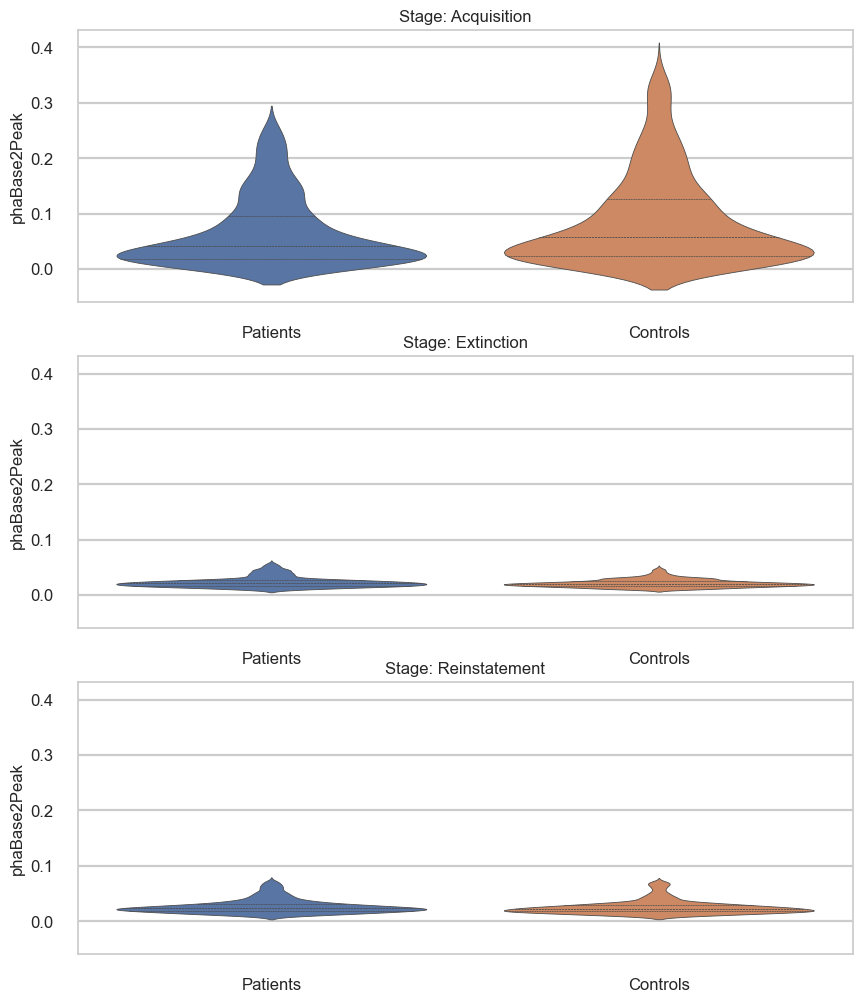

In [625]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame
# Set up the plotting style
#sns.set(style="whitegrid", palette="muted")
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-poster')
fontsize = 12
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})

# Define stages and groups
stages = ['acquisition', 'extinction', 'reinstatement']
groups = ['Patients', 'Controls']  # Match your data’s group names

# Create subplots: one row per stage
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharey=True)

# Iterate over stages and create violin plots
for i, stage in enumerate(stages):
    # Filter data for the current stage
    stage_data = df_cleaned[df_cleaned['stage'].str.lower() == stage.lower()]
    
    # Check if phaBase2Peak has any non-NaN data
    if stage_data['phaBase2Peak'].isna().all():
        print(f"No valid data for {stage.capitalize()} (all phaBase2Peak values are NaN)")
        axes[i].text(0.5, 0.5, f"No data for {stage.capitalize()}", 
                     ha='center', va='center', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        continue
    
    # Create violin plot
    sns.violinplot(
        data=stage_data,
        x='group',  # Groups on x-axis
        y='phaBase2Peak',
        hue='group',  # Color by group
        split=False,  # Full violins (not split)
        inner='quartile',  # Show quartiles inside violins
        ax=axes[i]
    )
    
    # Customize the subplot
    # Set y-axis limit to 0, 1
    #axes[i].set_ylim(0, 1)
    axes[i].set_title(f'Stage: {stage.capitalize()}')
    axes[i].set_xlabel('')
    if i == 1:
        axes[i].set_ylabel('phaBase2Peak')  # Center y-label

In [626]:
# Function to z-transform within-subject (across all stages for each sid)
def z_transform_within_subject(df, value_col='phaBase2Peak', id_col='sid'):
    # Group by sid to compute mean and std across all stages
    stats = df.groupby(id_col)[value_col].agg(['mean', 'std']).reset_index()
    
    # Merge stats back to the DataFrame
    df_z = df.merge(stats, on=id_col, how='left')
    
    # Compute z-scores: (value - mean) / std
    df_z[f'{value_col}_zscore'] = (df_z[value_col] - df_z['mean']) / df_z['std']
    
    # Handle potential NaN z-scores (e.g., if std = 0 for a subject)
    nan_count = df_z[f'{value_col}_zscore'].isna().sum()
    if nan_count > 0:
        print(f"Warning: Found {nan_count} NaN z-scores due to zero standard deviation. Replacing with 0.")
        df_z[f'{value_col}_zscore'] = df_z[f'{value_col}_zscore'].fillna(0)
    
    # Drop temporary columns
    df_z = df_z.drop(columns=['mean', 'std'])
    
    return df_z

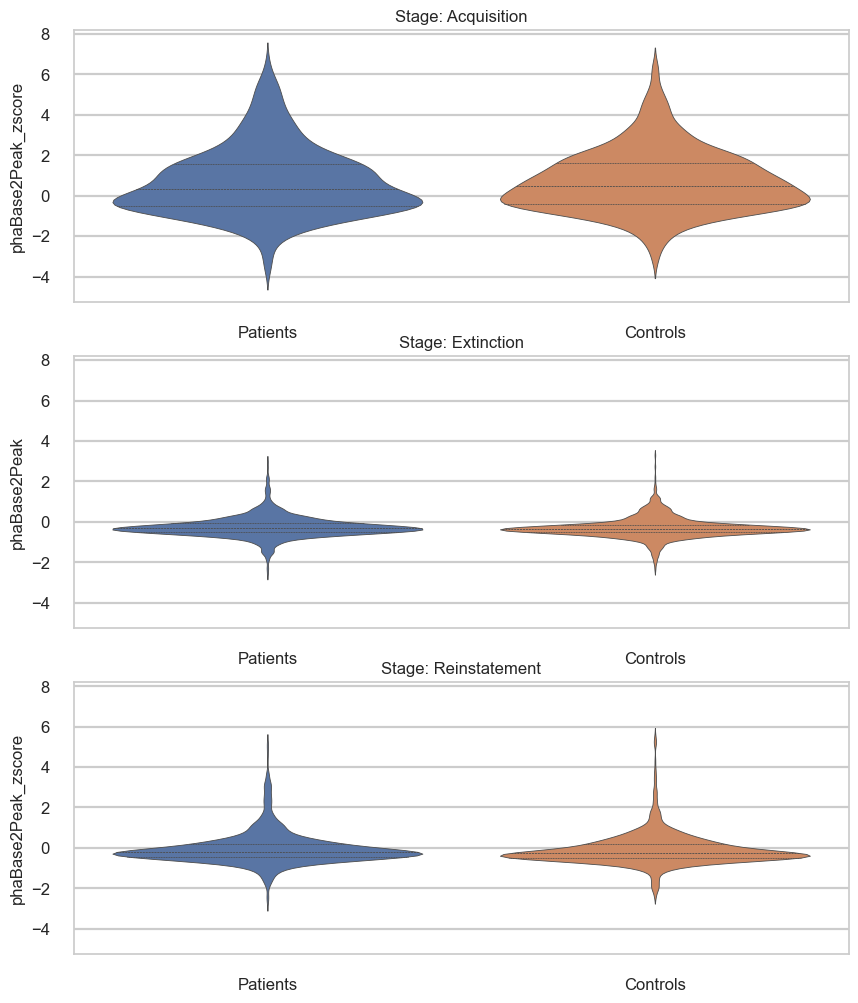

In [627]:
# Apply z-transformation
df_cleaned_z = z_transform_within_subject(df_cleaned)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharey=True)
# Iterate over stages and create violin plots
for i, stage in enumerate(stages):
    # Filter data for the current stage
    stage_data = df_cleaned_z[df_cleaned_z['stage'].str.lower() == stage.lower()]
    
    # Check if phaBase2Peak has any non-NaN data
    if stage_data['phaBase2Peak_zscore'].isna().all():
        print(f"No valid data for {stage.capitalize()} (all phaBase2Peak values are NaN)")
        axes[i].text(0.5, 0.5, f"No data for {stage.capitalize()}", 
                     ha='center', va='center', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        continue
    
    # Create violin plot
    sns.violinplot(
        data=stage_data,
        x='group',  # Groups on x-axis
        y='phaBase2Peak_zscore',
        hue='group',  # Color by group
        split=False,  # Full violins (not split)
        inner='quartile',  # Show quartiles inside violins
        ax=axes[i]
    )
    
    # Customize the subplot
    # Set y-axis limit to 0, 1
    #axes[i].set_ylim(0, 1)
    axes[i].set_title(f'Stage: {stage.capitalize()}')
    axes[i].set_xlabel('')
    if i == 1:
        axes[i].set_ylabel('phaBase2Peak')  # Center y-label

In [628]:
df_cleaned.columns

Index(['sid', 'stTy', 'stNum', 'bTime', 'tonBase', 'phaBase', 'phaMax',
       'phaBase2Peak', 'phaPeakLatency', 'phaMinLatency', 'USPeakLatency',
       'phaMaxUS', 'USminLatency', 'phaMinUS', 'USbase2peak', 'bad', 'stage',
       'CS_Type', 'subID', 'Drug', 'drug_condition', 'Gender', 'gender_code',
       'group', 'ecr_q1', 'ecr_q2', 'ecr_q3', 'ecr_q4', 'ecr_q5', 'ecr_q6',
       'ecr_q7', 'ecr_q8', 'ecr_q9', 'ecr_q10', 'ecr_q11', 'ecr_q12',
       'ecr_q13', 'ecr_q14', 'ecr_q15', 'ecr_q16', 'ecr_q17', 'ecr_q18',
       'ecr_q19', 'ecr_q20', 'ecr_q21', 'ecr_q22', 'ecr_q23', 'ecr_q24',
       'ecr_q25', 'ecr_q26', 'ecr_q27', 'ecr_q28', 'ecr_q29', 'ecr_q30',
       'ecr_q31', 'ecr_q32', 'ecr_q33', 'ecr_q34', 'ecr_q35', 'ecr_q36',
       'demo_age', 'demo_sex_at_birth', 'Anxiety', 'Avoidance', 'total_score',
       'rejTrials', 'outlier_flag_IQR', 'outlier_flag_MAD'],
      dtype='object')

In [629]:
# mixed effect model for df_cleaned
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
from scipy.stats import t, norm

# # Diagnostics: Check data structure and variance
# print("Data Summary:")
# print(df_responder.groupby(['stage', 'group'])['phaBase2Peak'].describe())
# print("\nObservations per subject per stage:")
# print(df_responder.groupby(['sid', 'stage']).size())
# print("\nNumber of subjects:", df_responder['sid'].nunique())
# print("\nVariance of phaBase2Peak by subject:")
# subject_vars = df_responder.groupby('sid')['phaBase2Peak'].var()
# print(subject_vars.describe())

model = mixedlm("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * CS_Type + Avoidance", 
                data=df_cleaned, 
                groups=df_cleaned["sid"], 
                re_formula="1")  # Random intercept for sid
result = model.fit(method='lbfgs')  # L-BFGS optimizer for stability
print("\nMixed ANOVA Results:")
print(result.summary())

# Check random effects variance
# if hasattr(result, 'random_effects_cov'):
#     print("\nRandom Effects Covariance:")
#     print(result.random_effects_cov)
#     re_variance = result.random_effects_cov.get('sid', 0)
#     if isinstance(re_variance, (int, float)) and re_variance < 1e-10:
#         print("Note: Random effects variance is effectively zero.")
#     elif isinstance(re_variance, dict) and re_variance.get('Intercept', 0) < 1e-10:
#         print("Note: Random effects variance (Intercept) is effectively zero.")

# Extract and z-transform t-statistics
t_stats = result.tvalues
df = result.df_resid
z_scores = pd.Series(index=t_stats.index)
for param in t_stats.index:
    t_val = t_stats[param]
    p_val = t.cdf(t_val, df) if t_val < 0 else 1 - t.cdf(t_val, df)
    z_val = norm.ppf(1 - p_val) * np.sign(t_val)
    z_scores[param] = z_val

print("\nZ-Transformed Statistics:")
z_df = pd.DataFrame({'t-statistic': t_stats, 'Z-score': z_scores})
print(z_df)



Mixed ANOVA Results:
                                              Mixed Linear Model Regression Results
Model:                                     MixedLM                        Dependent Variable:                        phaBase2Peak
No. Observations:                          4991                           Method:                                    REML        
No. Groups:                                101                            Scale:                                     0.0010      
Min. group size:                           12                             Log-Likelihood:                            9967.7004   
Max. group size:                           69                             Converged:                                 Yes         
Mean group size:                           49.4                                                                                  
------------------------------------------------------------------------------------------------------------------

/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [630]:
# Run MixedLM on z-scored data
#model = mixedlm("phaBase2Peak_zscore ~ C(stage) * C(group) * C(Drug) + Avoidance", 
model = mixedlm("phaBase2Peak_zscore ~ C(stage) * C(group) * C(Drug) * CS_Type", 
                data=df_cleaned_z, 
                groups=df_cleaned_z["sid"], 
                re_formula="1")
result = model.fit(method='lbfgs')

print("\nMixed ANOVA Results (Z-Scored):")
print(result.summary())

/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



Mixed ANOVA Results (Z-Scored):
                                             Mixed Linear Model Regression Results
Model:                                 MixedLM                      Dependent Variable:                      phaBase2Peak_zscore
No. Observations:                      4991                         Method:                                  REML               
No. Groups:                            101                          Scale:                                   0.8423             
Min. group size:                       12                           Log-Likelihood:                          -6693.8657         
Max. group size:                       69                           Converged:                               Yes                
Mean group size:                       49.4                                                                                     
--------------------------------------------------------------------------------------------------------------

/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [631]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from scipy.stats import t, norm

# # Diagnostics: Check data structure and ensure variables exist
# print("Data Summary of df_cleaned by stage, group, and other predictors:")
# print(df_cleaned.groupby(['stage', 'group'])['phaBase2Peak'].describe())
# print("\nSummary of Avoidance:")
# print(df_cleaned['Avoidance'].describe())
# print("\nSummary of age:")
# print(df_cleaned['demo_age'].describe())
# print("\nSummary of gender:")
# print(df_cleaned['Gender'].value_counts(dropna=False))


# Aggregate to mean per sid, stage, group (ensuring no NaNs in key columns)
df_aggregated = df_cleaned.groupby(['sid', 'stage', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()

# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df_cleaned.groupby(['sid', 'stage', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)

# Verify aggregated data
print(f"\nAggregated DataFrame size: {df_aggregated.shape}")
print("Unique sids in aggregated data:", df_aggregated['sid'].nunique())
print("\nSample of aggregated data:")
print(df_aggregated.head())

# Run fixed-effects OLS with all predictors
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * C(CS_Type) * C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results C(stage) * C(group) * C(Drug) * C(CS_Type) * C(Gender:")
print(result_ols.summary())

# Z-transform t-statistics
t_stats_ols = result_ols.tvalues
df_ols = result_ols.df_resid
print(f"Number of t-statistics: {len(t_stats_ols)}, Residual df: {df_ols}")

z_scores_ols = pd.Series(index=t_stats_ols.index)
for param in t_stats_ols.index:
    t_val = t_stats_ols[param]
    p_val = t.cdf(t_val, df_ols) if t_val < 0 else 1 - t.cdf(t_val, df_ols)
    z_val = norm.ppf(1 - p_val) * np.sign(t_val)
    z_scores_ols[param] = z_val

print("\nZ-Transformed Statistics (Aggregated Fixed-Effects):")
z_df_ols = pd.DataFrame({'t-statistic': t_stats_ols, 'Z-score': z_scores_ols})
print(z_df_ols)
z_df_ols.to_csv('aggregated_anova_zscores_with_confounders.csv')


Aggregated DataFrame size: (851, 9)
Unique sids in aggregated data: 101

Sample of aggregated data:
    sid        stage     group     Drug    CS_Type  phaBase2Peak  Avoidance  \
0  N101  acquisition  Patients  Placebo  CS+_Reinf      0.039000       66.0   
1  N101  acquisition  Patients  Placebo   CS+_Safe      0.068000       66.0   
2  N101  acquisition  Patients  Placebo        CS-      0.045000       66.0   
3  N101   extinction  Patients  Placebo  CS+_Reinf      0.024286       66.0   
4  N101   extinction  Patients  Placebo   CS+_Safe      0.022125       66.0   

   demo_age  Gender  
0      21.0  Female  
1      21.0  Female  
2      21.0  Female  
3      21.0  Female  
4      21.0  Female  

Fixed-Effects OLS Results C(stage) * C(group) * C(Drug) * C(CS_Type) * C(Gender:
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.385
Model:                            OLS   Adj. R-squar

### Age/Gender: 
Non-significant (p > 0.05), suggesting they’re not confounders in this context.
### Multicollinearity
Models 1 and 2 have extreme condition numbers (2.41e+18, 1.20e+18), indicating severe multicollinearity, likely from Avoidance interactions and age/gender.
Models 3 and 4 show reduced multicollinearity (1.89e+03, 458), with Model 4 being the most stable, suggesting * Avoidance interactions are redundant.
Thresholds for Concern:
Small Condition Number (e.g., < 10): Indicates no significant multicollinearity or numerical issues. The model is stable, and coefficient estimates are reliable.
Moderate Condition Number (e.g., 10–100): Suggests potential multicollinearity or numerical instability, warranting further investigation (e.g., VIF, correlation checks).
High Condition Number (e.g., 100–1,000): Indicates moderate to strong multicollinearity or numerical problems, potentially affecting coefficient precision and standard errors.
Very High Condition Number (e.g., >1,000 or 1e+03 to 1e+18): Suggests severe multicollinearity, a singular or nearly singular design matrix, or numerical instability, making coefficient estimates unreliable and p-values questionable.
### Non-Normality
All models show significant non-normality (skewness 2.471–3.007, kurtosis 14.124–17.013), requiring transformation (e.g., log1p) or outlier checks on phaBase2Peak.
|Skewness| < 0.5
|Excess Kurtosis| < 1.0

In [632]:
### full model: C(stage) * C(group) * C(Drug) * C(CS_Type)
df = df_cleaned.copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * C(CS_Type) + Avoidance + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type) + Avoidance + demo_age + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * C(CS_Type) + Avoidance", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type) + Avoidance):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * C(CS_Type) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type) + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * C(CS_Type)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type) + Avoidance + demo_age + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     11.06
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           2.42e-51
Time:                        10:58:06   Log-Likelihood:                 1733.1
No. Observations:                 851   AIC:                            -3388.
Df Residuals:                     812   BIC:                            -3203.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                                                               coef   

In [633]:
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(Drug) * C(CS_Type) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type) + C(Gender)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(stage) * C(group) * C(Drug) * C(CS_Type) + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     11.59
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           7.57e-52
Time:                        10:59:40   Log-Likelihood:                 1731.6
No. Observations:                 851   AIC:                            -3389.
Df Residuals:                     814   BIC:                            -3214.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                                               coef    std err          t    

### Non-Normality: 
All models show significant non-normality in residuals (Omnibus p < 0.001, skewness 2.445–2.803, kurtosis 13.822–15.810), indicating potential issues with skewness or outliers in phaBase2Peak.
### Durbin-Watson: 
Close to 2 (1.782–1.933), suggesting no significant autocorrelation in residuals.

### Non-Normality:
Log-transformation reduced but didn’t eliminate non-normality (skewness 2.232–2.812, kurtosis 12.623–15.661). Re-check outliers or try additional transformations (e.g., square root) or robust methods:

#### Non-Normality:
sqrt transform did not solve 

In [634]:
# Post-hoc test (Tukey HSD) on raw data
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(df_cleaned['phaBase2Peak'], 
                            df_cleaned['stage'] + "_" + df_cleaned['group'] + "_" + df_cleaned['Drug'] + "_"  + df_cleaned['CS_Type'], 
                            alpha=0.05)
print("\nPost-Hoc Tukey HSD Results:")
print(posthoc)


Post-Hoc Tukey HSD Results:
                                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                                    
                  group1                                    group2                  meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------
  acquisition_Controls_Oxytocin_CS+_Reinf    acquisition_Controls_Oxytocin_CS+_Safe  -0.0019    1.0 -0.0231  0.0192  False
  acquisition_Controls_Oxytocin_CS+_Reinf         acquisition_Controls_Oxytocin_CS-  -0.0124 0.9239 -0.0325  0.0078  False
  acquisition_Controls_Oxytocin_CS+_Reinf    acquisition_Controls_Placebo_CS+_Reinf  -0.0044    1.0 -0.0245  0.0158  False
  acquisition_Controls_Oxytocin_CS+_Reinf     acquisition_Controls_Placebo_CS+_Safe  -0.0028    1.0 -0.0226   0.017  False
  acquisition_Controls_Oxytocin_CS+_Reinf          acquisition_Controls_Placebo_CS-  -0.0144 0.6597 -0.0344  0

## The whole model is not suitable (mixed-effect model: stage * group * drug * CS_type)

In [635]:
## roll back, stage* group  * drug * CS_type effect for before drug phase.
# mixed effect model for df_cleaned_acquisition
model = mixedlm("phaBase2Peak ~  C(group) * CS_Type + Avoidance", 
                data=df_cleaned_acquisition, 
                groups=df_cleaned_acquisition["sid"], 
                re_formula="1")  # Random intercept for sid
result = model.fit(method='lbfgs')  # L-BFGS optimizer for stability
print("\nMixed ANOVA Results:C(group) * CS_Type + Avoidance")
print(result.summary())
model = mixedlm("phaBase2Peak ~ C(group) * CS_Type", 
                data=df_cleaned_acquisition, 
                groups=df_cleaned_acquisition["sid"], 
                re_formula="1")  # Random intercept for sid
result = model.fit(method='lbfgs')  # L-BFGS optimizer for stability
print("\nMixed ANOVA Results:C(group) * CS_Type")
print(result.summary())


Mixed ANOVA Results:C(group) * CS_Type + Avoidance
                       Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         phaBase2Peak
No. Observations:          1628            Method:                     REML        
No. Groups:                102             Scale:                      0.0003      
Min. group size:           1               Log-Likelihood:             4270.7879   
Max. group size:           24              Converged:                  Yes         
Mean group size:           16.0                                                    
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.025    0.004  6.685 0.000  0.018  0.032
C(group)[T.Patients]                     -0.011

/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [636]:
# fixed effect model for before drug phase
df = df_cleaned_acquisition.copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.479
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           4.61e-09
Time:                        11:00:21   Log-Likelihood:                 808.15
No. Observations:                 296   AIC:                            -1598.
Df Residuals:                     287   BIC:                            -1565.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--

In [637]:
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.479
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           4.61e-09
Time:                        11:02:08   Log-Likelihood:                 808.15
No. Observations:                 296   AIC:                            -1598.
Df Residuals:                     287   BIC:                            -1565.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---

In [638]:
## roll back, stage* group  * drug * CS_type effect for after drug phase.
# mixed effect model for df_cleaned_phase2and3
model = mixedlm("phaBase2Peak ~  C(stage) * C(group) * CS_Type + Avoidance", 
                data=df_cleaned_phase2and3, 
                groups=df_cleaned_phase2and3["sid"], 
                re_formula="1")  # Random intercept for sid
result = model.fit(method='lbfgs')  # L-BFGS optimizer for stability
print("\nMixed ANOVA Results:C(stage) * C(group) * CS_Type + Avoidance")
print(result.summary())
model = mixedlm("phaBase2Peak ~ C(stage) * C(group) * CS_Type", 
                data=df_cleaned_phase2and3, 
                groups=df_cleaned_phase2and3["sid"], 
                re_formula="1")  # Random intercept for sid
result = model.fit(method='lbfgs')  # L-BFGS optimizer for stability
print("\nMixed ANOVA Results:C(stage) * C(group) * CS_Type")
print(result.summary())


Mixed ANOVA Results:C(stage) * C(group) * CS_Type + Avoidance
                                    Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  phaBase2Peak
No. Observations:                  4050                     Method:                              REML        
No. Groups:                        101                      Scale:                               0.0001      
Min. group size:                   2                        Log-Likelihood:                      13325.9978  
Max. group size:                   48                       Converged:                           Yes         
Mean group size:                   40.1                                                                      
-------------------------------------------------------------------------------------------------------------
                                                                   Coef.  Std.Err.   z    P>|

/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/xiaoqianxiao/PycharmProjects/aboutLive/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [644]:
## fix effect model for df_cleaned_phase2and3
df = df_cleaned_phase2and3.copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid','stage','group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid','stage','group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type) + Avoidance_centered):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type) + demo_age + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.055
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           9.66e-07
Time:                        11:05:46   Log-Likelihood:                 2025.8
No. Observations:                 598   AIC:                            -4022.
Df Residuals:                     583   BIC:                            -3956.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t 

In [645]:
model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) * C(Drug) + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type) * C(Drug) + demo_age + C(Gender)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(stage) * C(group) * C(CS_Type) * C(Drug) + demo_age + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.508
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           8.43e-05
Time:                        11:05:48   Log-Likelihood:                 2029.2
No. Observations:                 598   AIC:                            -4006.
Df Residuals:                     572   BIC:                            -3892.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                                               coef    std err    

In [646]:
# fixed effect model for extinction
df = df_cleaned_phase2and3.loc[df_cleaned_phase2and3['stage']=='extinction'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.286
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.251
Time:                        11:06:42   Log-Likelihood:                 1057.6
No. Observations:                 299   AIC:                            -2097.
Df Residuals:                     290   BIC:                            -2064.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--

In [647]:
# fixed effect model for reinstatement
df = df_cleaned_phase2and3.loc[df_cleaned_phase2and3['stage']=='reinstatement'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type) + C(Gender)):")
print(result_ols.summary())
model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS_Type)):")
print(result_ols.summary())


Fixed-Effects OLS Results (C(group) * C(CS_Type) + Avoidance_centered + demo_age + C(Gender)):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.537
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.144
Time:                        11:07:56   Log-Likelihood:                 979.94
No. Observations:                 299   AIC:                            -1942.
Df Residuals:                     290   BIC:                            -1909.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--


Fixed-Effects OLS Results (C(group) * C(CS) * C(Gender) + Avoidance_centered + demo_age):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4.933
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           5.83e-06
Time:                        13:28:04   Log-Likelihood:                 562.75
No. Observations:                 201   AIC:                            -1105.
Df Residuals:                     191   BIC:                            -1072.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]

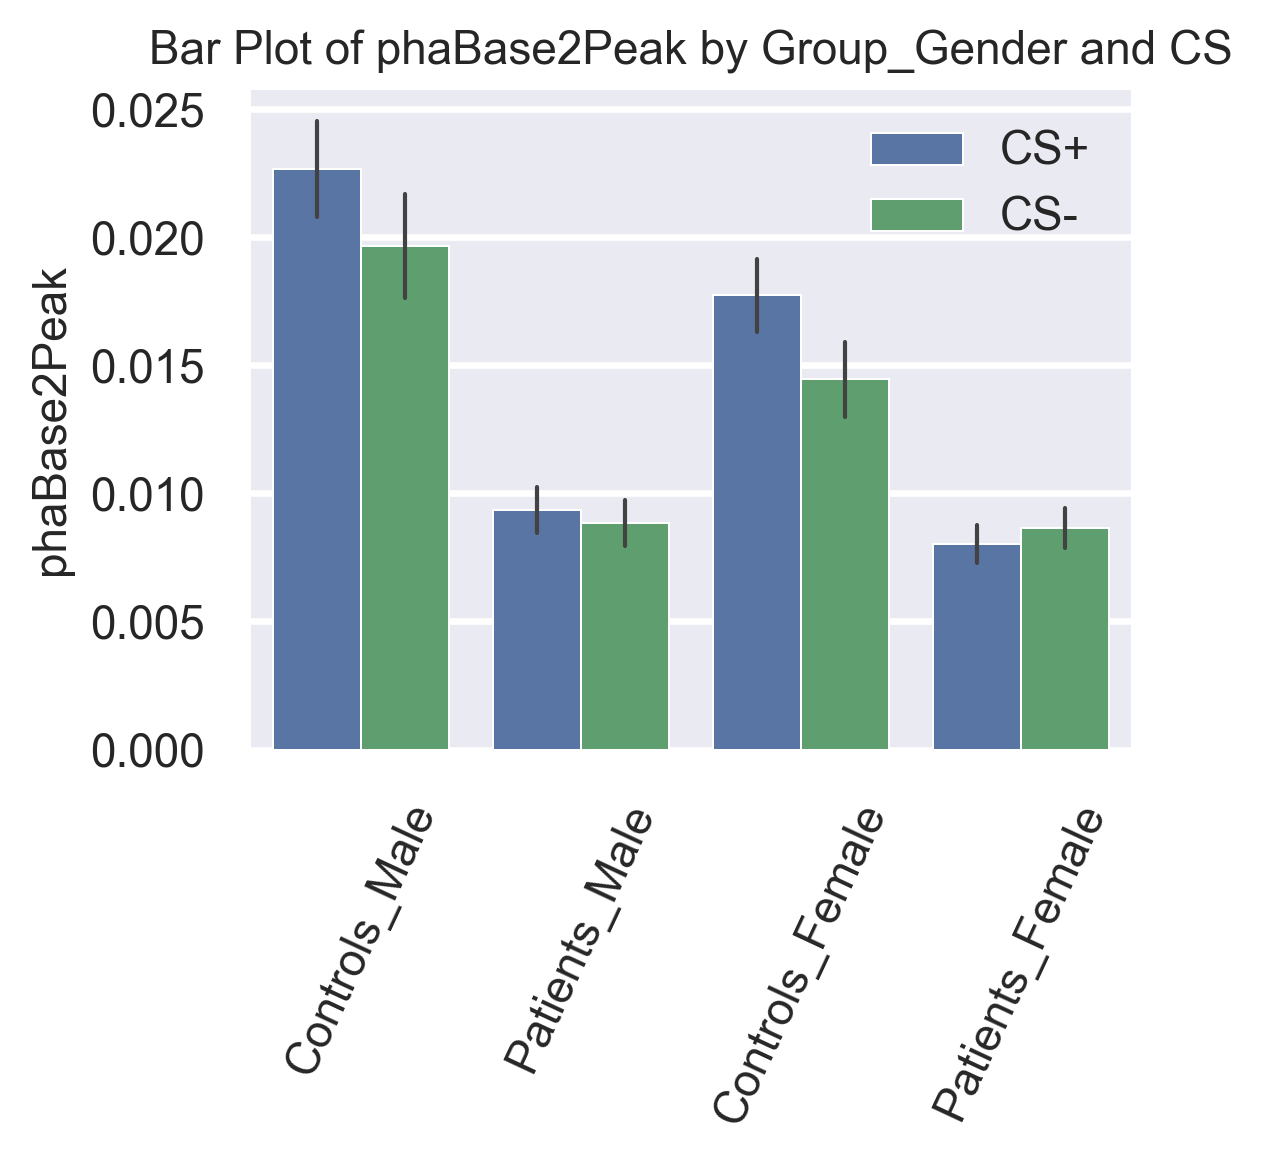

In [689]:
df = df_cleaned_acquisition
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Group_Gender'] = df['group'] + '_' + df['Gender']

# Correct way to update values in 'CS' column
df['CS'] = 'CS+'  # Default to 'CS+'
df.loc[df['CS_Type'] == 'CS-', 'CS'] = 'CS-'  # Modify only where CS_Type is 'CS-'
x_order = ['Controls_Male', 
           'Patients_Male',
           'Controls_Female',
           'Patients_Female']  # Modify drug names if different


df_aggregated = df.groupby(['sid', 'group','CS'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'group','Drug','CS'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()
model_ols = ols("phaBase2Peak ~ C(group) * C(CS) * C(Gender) + Avoidance_centered + demo_age", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS) * C(Gender) + Avoidance_centered + demo_age):")
print(result_ols.summary())

model_ols = ols("phaBase2Peak ~ C(group) * C(CS) * C(Gender) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS) * C(Gender) + Avoidance_centered):")
print(result_ols.summary())

model_ols = ols("phaBase2Peak ~ C(group) * C(CS) * C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS) * C(Gender)):")
print(result_ols.summary())

model_ols = ols("phaBase2Peak ~ C(group) * C(CS) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) * C(CS) + C(Gender)):")
print(result_ols.summary())

model_ols = ols("phaBase2Peak ~ C(group) + C(CS) + C(Gender)", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results (C(group) + C(CS) + C(Gender)):")
print(result_ols.summary())

# Create bar plot
plt.style.use('seaborn-v0_8-poster')
#plt.style.use('seaborn-v0_8')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(
        data=df,
        x='Group_Gender',
        y='phaBase2Peak',
        hue='CS',
        order=x_order,
        errorbar='se',
        err_kws={'linewidth': 1},
        ax=ax
    )


# Labels and formatting
plt.xlabel('')
plt.ylabel('phaBase2Peak')
plt.title('Bar Plot of phaBase2Peak by Group_Gender and CS')
# Customize the legend position
plt.legend(title='', fontsize=fontsize)
plt.xticks(rotation=65)
plt.tight_layout()
plt.show()

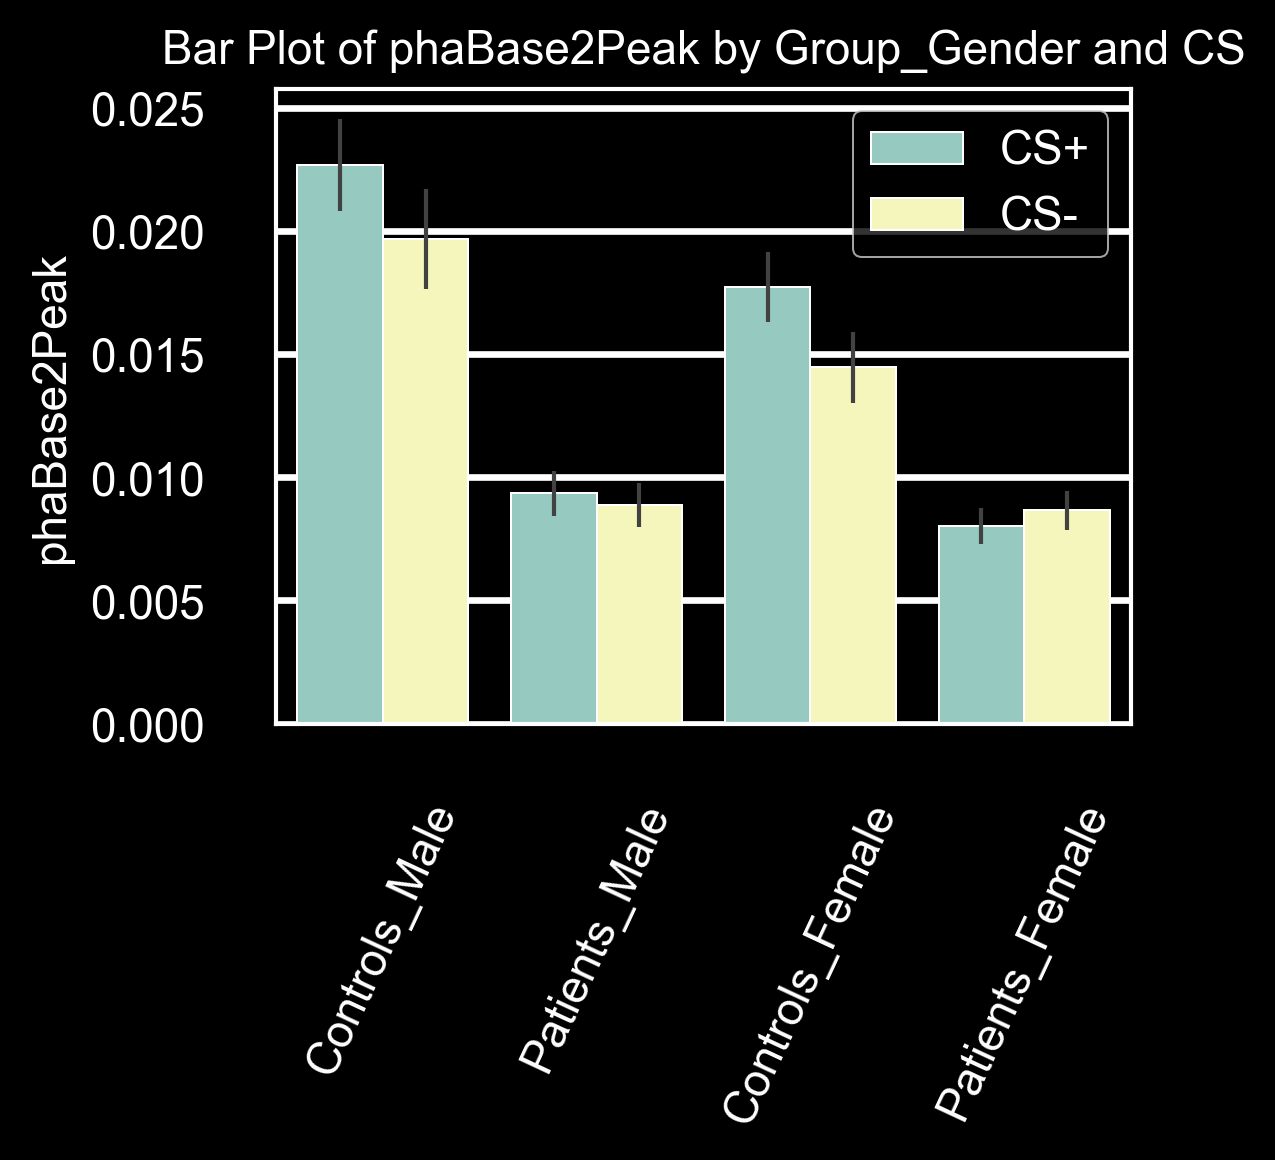

In [680]:
df = df_cleaned_acquisition
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Group_Gender'] = df['group'] + '_' + df['Gender']

# Correct way to update values in 'CS' column
df['CS'] = 'CS+'  # Default to 'CS+'
df.loc[df['CS_Type'] == 'CS-', 'CS'] = 'CS-'  # Modify only where CS_Type is 'CS-'
x_order = ['Controls_Male', 
           'Patients_Male',
           'Controls_Female',
           'Patients_Female']  # Modify drug names if different


# Create bar plot
plt.style.use('seaborn-v0_8-poster')
#plt.style.use('dark_background')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(
        data=df,
        x='Group_Gender',
        y='phaBase2Peak',
        hue='CS',
        order=x_order,
        errorbar='se',
        err_kws={'linewidth': 1},
        ax=ax
    )


# Labels and formatting
plt.xlabel('')
plt.ylabel('phaBase2Peak')
plt.title('Bar Plot of phaBase2Peak by Group_Gender and CS')
# Customize the legend position
plt.legend(title='', fontsize=fontsize)
plt.xticks(rotation=65)
plt.tight_layout()
plt.show()



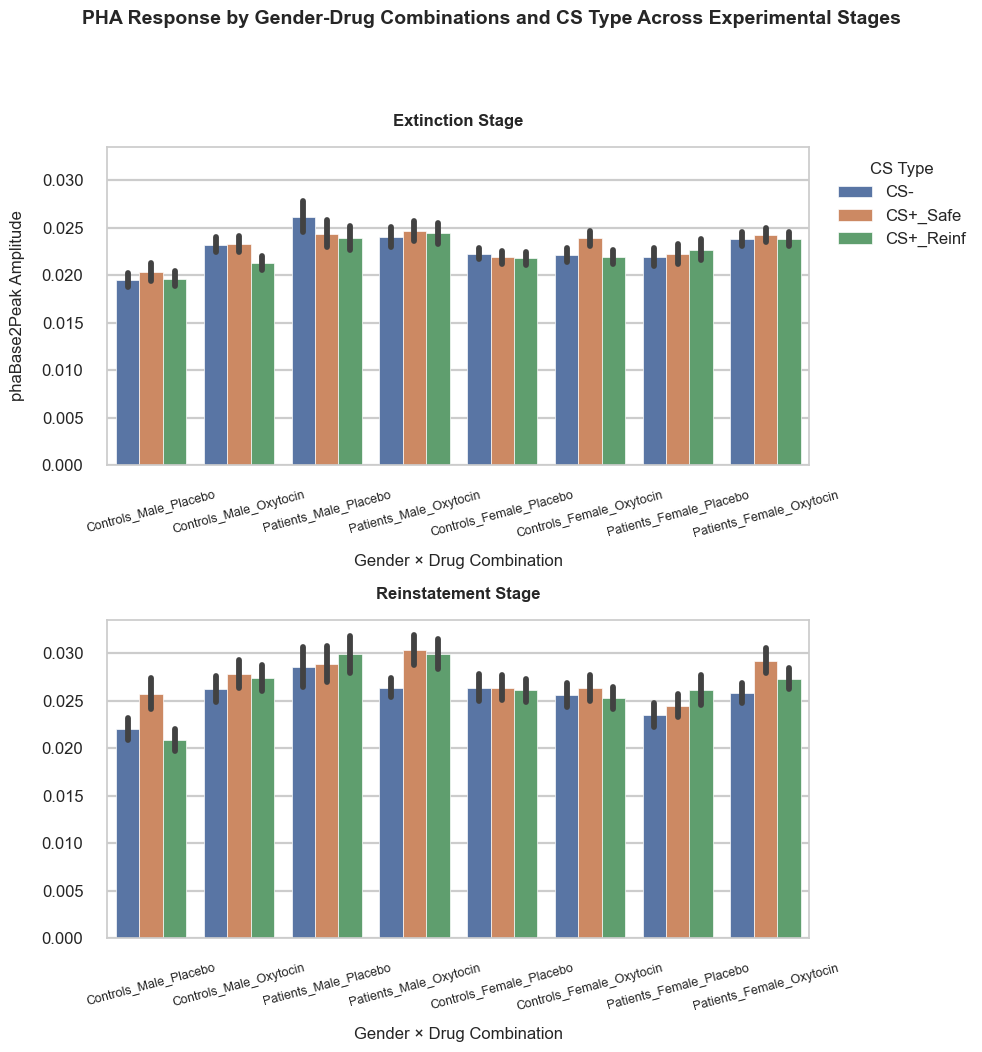

In [652]:
df = df_cleaned_phase2and3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create interaction term for x-axis
df['Group_Gender_Drug'] = df['group'] + '_' + df['Gender'] + '_' + df['Drug']

# Set up plot
stages = df['stage'].unique()
n_stages = len(stages)
fig, axes = plt.subplots(n_stages, 1, figsize=(10, 10), sharey=True)
plt.subplots_adjust(wspace=0.2)

# Define consistent formatting
#cs_palette = {'CS+_Safe': '#1f77b4', 'CS-': '#ff7f0e', 'CS+': '#2ca02c'}  # Modify as needed
cs_order = ['CS-', 'CS+_Safe', 'CS+_Reinf']
df['CS_Type'] = pd.Categorical(df['CS_Type'], categories=cs_order, ordered=True)
x_order = ['Controls_Male_Placebo', 
           'Controls_Male_Oxytocin', 
           'Patients_Male_Placebo',
           'Patients_Male_Oxytocin',
           'Controls_Female_Placebo',
          'Controls_Female_Oxytocin',
           'Patients_Female_Placebo',
          'Patients_Female_Oxytocin']  # Modify drug names if different

for ax, stage in zip(axes, stages):
    stage_data = df[df['stage'] == stage]
    
    # Create nested bar plot
    sns.barplot(
        data=stage_data,
        x='Group_Gender_Drug',
        y='phaBase2Peak',
        hue='CS_Type',
        order=x_order,
        errorbar='se',
        ax=ax
    )
    
    # Formatting
    ax.set_title(f"{stage.capitalize()} Stage", fontweight='bold', pad=15)
    ax.set_xlabel('Gender × Drug Combination', labelpad=10)
    ax.tick_params(axis='x', rotation=15, labelsize=9)
    
    # Remove redundant labels
    if ax != axes[0]:
        ax.set_ylabel('')
        ax.get_legend().remove()
    else:
        ax.legend(
            title='CS Type',
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            frameon=False
        )
        ax.set_ylabel('phaBase2Peak Amplitude', labelpad=12)

# Add common elements
plt.suptitle("PHA Response by Gender-Drug Combinations and CS Type Across Experimental Stages", 
            y=1.05, fontsize=14, fontweight='bold')
plt.tight_layout()

# Add manual spacing between subplots
plt.subplots_adjust(wspace=0.15)

plt.show()

In [ ]:
unexpected omission: prediction error driving extinction learning)?

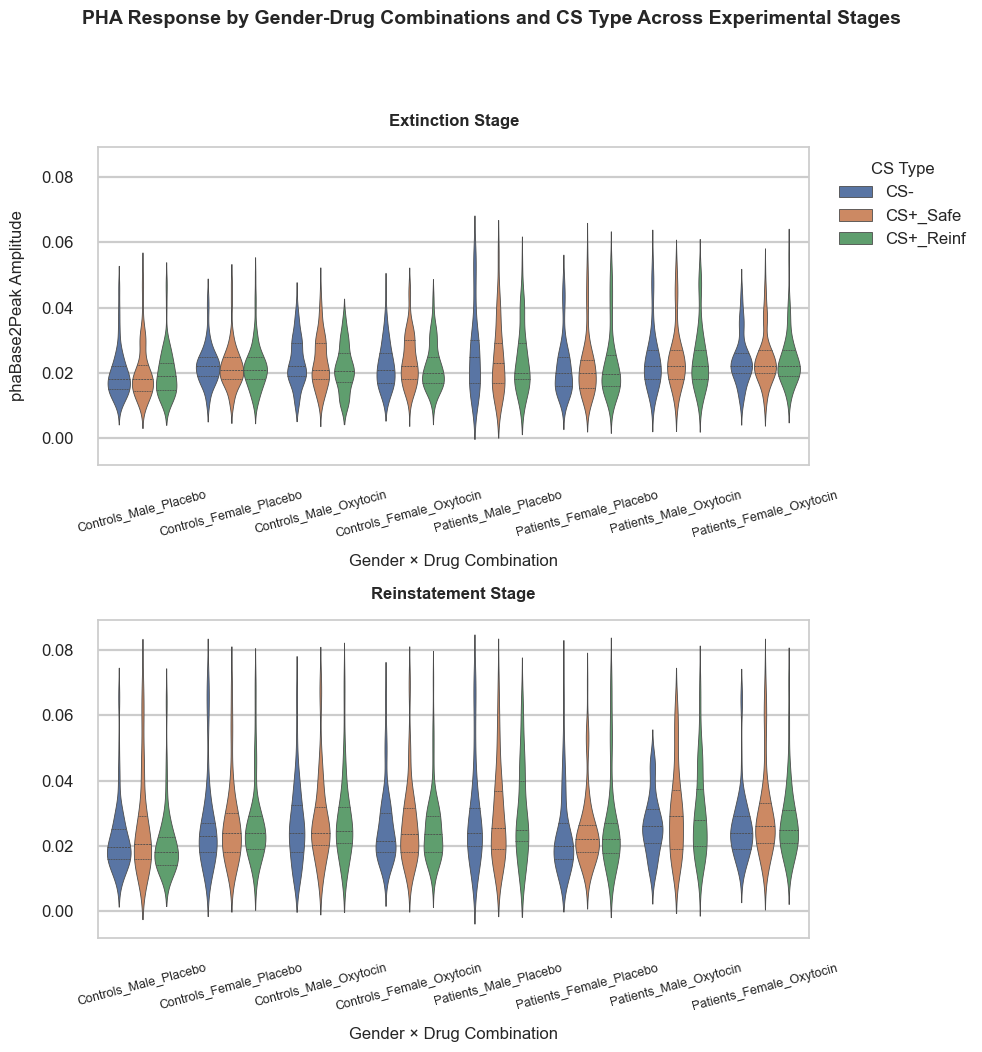

In [650]:
df = df_cleaned_phase2and3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['Group_Gender_Drug'] = df['group'] + '_' + df['Gender'] + '_' + df['Drug']

# Set up plot
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-poster')
fontsize = 12
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})

stages = df['stage'].unique()
n_stages = len(stages)
fig, axes = plt.subplots(n_stages, 1, figsize=(10, 10), sharey=True)


# Define consistent formatting
#cs_palette = {'CS+_Safe': '#1f77b4', 'CS-': '#ff7f0e', 'CS+': '#2ca02c'}  # Modify as needed
cs_order = ['CS-', 'CS+_Safe', 'CS+_Reinf']
df['CS_Type'] = pd.Categorical(df['CS_Type'], categories=cs_order, ordered=True)
x_order = ['Controls_Male_Placebo', 
           'Controls_Female_Placebo', 
           'Controls_Male_Oxytocin', 
          'Controls_Female_Oxytocin',
           'Patients_Male_Placebo', 
           'Patients_Female_Placebo', 
           'Patients_Male_Oxytocin', 
          'Patients_Female_Oxytocin']  # Modify drug names if different


for ax, stage in zip(axes, stages):
    stage_data = df[df['stage'] == stage]
    
    # Create nested bar plot
    sns.violinplot(
        data=stage_data,
        x='Group_Gender_Drug',  # Groups on x-axis
        y='phaBase2Peak',
        hue='CS_Type',  # Color by group
        split=False,  # Full violins (not split)
        inner='quartile',  # Show quartiles inside violins
        order=x_order,
        ax=ax
    )
    
    # Formatting
    ax.set_title(f"{stage.capitalize()} Stage", fontweight='bold', pad=15)
    ax.set_xlabel('Gender × Drug Combination', labelpad=10)
    ax.tick_params(axis='x', rotation=15, labelsize=9)
    
    # Remove redundant labels
    if ax != axes[0]:
        ax.set_ylabel('')
        ax.get_legend().remove()
    else:
        ax.legend(
            title='CS Type',
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            frameon=False
        )
        ax.set_ylabel('phaBase2Peak Amplitude', labelpad=12)

# Add common elements
plt.suptitle("PHA Response by Gender-Drug Combinations and CS Type Across Experimental Stages", 
            y=1.05, fontsize=14, fontweight='bold')
plt.tight_layout()

# Add manual spacing between subplots
plt.subplots_adjust(wspace=0.15)

plt.show()

Help on function violinplot in module seaborn.categorical:

violinplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, fill=True, inner='box', split=False, width=0.8, dodge='auto', gap=0, linewidth=None, linecolor='auto', cut=2, gridsize=100, bw_method='scott', bw_adjust=1, density_norm='area', common_norm=False, hue_norm=None, formatter=None, log_scale=None, native_scale=False, legend='auto', scale=<deprecated>, scale_hue=<deprecated>, bw=<deprecated>, inner_kws=None, ax=None, **kwargs)
    Draw a patch representing a KDE and add observations or box plot statistics.

    A violin plot plays a similar role as a box-and-whisker plot. It shows the
    distribution of data points after grouping by one (or more) variables.
    Unlike a box plot, each violin is drawn using a kernel density estimate
    of the underlying distribution.

    See the :ref:`tutorial <categorical_tutorial>` for more information.

    .. n